In [2]:
import sys
import os
REPO_DIR = "../"
sys.path.append(REPO_DIR)

In [3]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scripts.preprocessing import *
from helpers.model_handler import *

In [4]:
NUM_CPU = os.cpu_count() if os.cpu_count() is not None else 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE, NUM_CPU)

TRAINING_SIZE = 700
BATCH_SIZE = 32
NUM_EPOCHS = 60
BASE_LR = 0.0001

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

cuda 2


In [5]:
train_dir = REPO_DIR + "dataset/training/"
train_images_filename = train_dir + "augmented_images/"
train_masks_filename = train_dir + "aumented_groundtruth/"

train_images = extract_data(train_images_filename, TRAINING_SIZE)
train_masks = extract_data(train_masks_filename, TRAINING_SIZE)
print(f"Input shapes: {train_images.shape, train_masks.shape}")

Loading ml-project-2-pytyeee/dataset/training/images/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/images/satImage_100.png
Loading ml-project-2-pytyeee/dataset/training/groundtruth/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/groundtruth/satImage_100.png
Input shapes: ((100, 400, 400, 3), (100, 400, 400))


In [6]:
# Resize images to a size divisible by 32 to make it UNet compatible
train_data = img_resize(np.transpose(train_images, (0, 3, 1, 2)), (416, 416))
train_labels = img_resize(np.transpose(np.expand_dims(train_masks, -1), (0, 3, 1, 2)),  (416, 416))

# 1 hot encode each non black pixel to 1 pixel
train_labels[train_labels > 0] = 1
print(f"New shapes: {train_data.shape, train_labels.shape}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


New shapes: (torch.Size([100, 3, 416, 416]), torch.Size([100, 1, 416, 416]))


In [8]:
train_data, val_data, train_labels, val_labels = split_data(train_data, train_labels, 0.8, seed=438)

Data split on ratio 0.8: TRAINING torch.Size([320, 3, 224, 224]) & torch.Size([320, 1, 224, 224]) and TEST torch.Size([80, 3, 224, 224]) & torch.Size([80, 1, 224, 224])


In [10]:
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1, # 1 for grayscale
    activation=ACTIVATION,
)

model = model.to(DEVICE)

In [11]:
VAL_SIZE = 64 # val_data.shape[0]
print(VAL_SIZE)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CPU)
val_loader = DataLoader(val_dataset, batch_size=VAL_SIZE, shuffle=False, num_workers=NUM_CPU)

16


In [12]:
criterion = smp.losses.DiceLoss('binary')

optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

In [13]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, val_loader, epoch, device):
    # ***************************************************
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()

    tr_loss_history = []
    tr_accuracy_history = []
    lr_history = []

    loss_history = []
    accuracy_history = []
    f1_score_history = []
    iou_score_history = []

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        tr_loss = criterion(output, target)
        tr_loss.backward()
        optimizer.step()
        scheduler.step()

        tp, fp, fn, tn = smp.metrics.get_stats(output, target.to(int), mode='binary', threshold=0.5)
        tr_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
        tr_loss_float = tr_loss.item()

        if batch_idx % 10 == 0:
          print(
              f"Train Epoch: {epoch}-{batch_idx:03d} "
              f"batch_loss={tr_loss_float:0.2e} "
              f"batch_acc={tr_accuracy:0.3f} "
              f"lr={scheduler.get_last_lr()[0]:0.3e} "
          )

        tr_loss_history.append(tr_loss_float)
        tr_accuracy_history.append(tr_accuracy)
        lr_history.append(scheduler.get_last_lr()[0])

    model.eval()
    # Add validation loss, iou, f1 and accuracy
    img_loss, img_iou, img_f1, img_acc = [], [], [], []

    with torch.no_grad():

      for val_idx, (data, target) in enumerate(val_loader):

        data, target = data.to(device), target.to(device)
        output = model(data)

        tp, fp, fn, tn = smp.metrics.get_stats(output, target.to(int), mode='binary', threshold=0.5)

        img_loss.append(criterion(output, target).item())
        img_iou.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro"))
        img_f1.append(smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro"))
        img_acc.append(smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro"))

    loss = np.mean(img_loss)
    iou_score = np.mean([t.item() for t in img_iou])
    f1_score = np.mean([t.item() for t in img_f1])
    accuracy = np.mean([t.item() for t in img_acc])

    print(
        f"\nValidation: "
        f"loss={loss:0.2e} "
        f"accuracy={accuracy:0.3f} "
        f"iou_score={iou_score:0.3f} "
        f"f1_score={f1_score:0.3f}\n"
    )

    return tr_loss_history, tr_accuracy_history, lr_history, loss, accuracy, f1_score, iou_score, output, target

In [14]:
lrs = []
tr_losses = []
tr_accs = []
losses = []
ious = []
accs = []
f1s = []
for epoch in range(1, NUM_EPOCHS + 1):
    
    tr_loss, tr_acc, lr, loss, acc, f1, iou, out, tar = train_epoch(
        model, optimizer, lr_scheduler, criterion, train_loader, val_loader, epoch, DEVICE
    )
    tr_losses.extend(tr_loss)
    tr_accs.extend(tr_acc)
    lrs.extend(lr)
    losses.append(loss)
    accs.append(acc)
    ious.append(iou)
    f1s.append(f1)

Train Epoch: 1-000 batch_loss=6.62e-01 batch_acc=0.325 lr=1.000e-04 
Train Epoch: 1-010 batch_loss=6.09e-01 batch_acc=0.302 lr=1.000e-04 

Validation: loss=6.22e-01 accuracy=0.581 iou_score=0.126 f1_score=0.224

Train Epoch: 2-000 batch_loss=6.27e-01 batch_acc=0.310 lr=1.000e-04 
Train Epoch: 2-010 batch_loss=6.52e-01 batch_acc=0.350 lr=1.000e-04 

Validation: loss=6.09e-01 accuracy=0.489 iou_score=0.157 f1_score=0.271

Train Epoch: 3-000 batch_loss=6.18e-01 batch_acc=0.425 lr=1.000e-04 
Train Epoch: 3-010 batch_loss=6.21e-01 batch_acc=0.507 lr=1.000e-04 

Validation: loss=5.97e-01 accuracy=0.474 iou_score=0.181 f1_score=0.306

Train Epoch: 4-000 batch_loss=6.41e-01 batch_acc=0.574 lr=1.000e-04 
Train Epoch: 4-010 batch_loss=6.21e-01 batch_acc=0.611 lr=1.000e-04 

Validation: loss=5.95e-01 accuracy=0.563 iou_score=0.207 f1_score=0.342

Train Epoch: 5-000 batch_loss=6.15e-01 batch_acc=0.579 lr=1.000e-04 
Train Epoch: 5-010 batch_loss=6.85e-01 batch_acc=0.617 lr=1.000e-04 

Validation: l

NameError: ignored

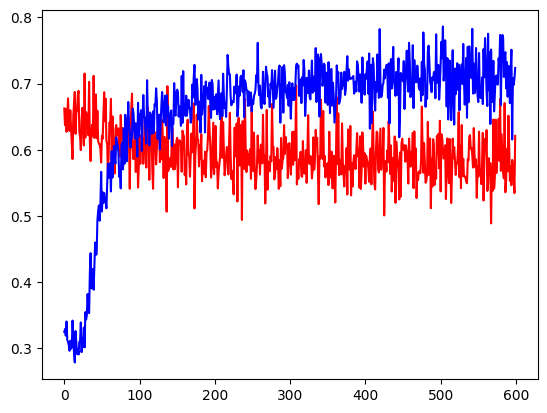

In [15]:
# Scatter plot
time_axis = np.arange(len(tr_losses))
plt.plot(time_axis, tr_losses, label='Train batch loss', color='red')
plt.plot(time_axis, tr_accs, label='Train batch accuracy', color='blue')
plt.xlabel('Batches')
plt.legend()
plt.show()

<ipython-input-16-a0993fd426cc>:1: RuntimeWarning: invalid value encountered in divide
  lrs_norm = (lrs-np.min(lrs))/(np.max(lrs)-np.min(lrs))


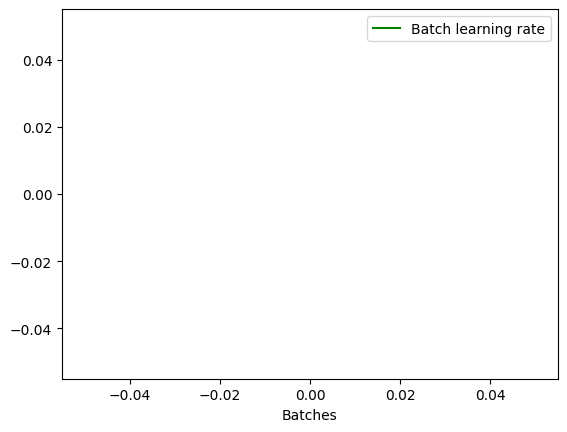

In [16]:
lrs_norm = (lrs-np.min(lrs))/(np.max(lrs)-np.min(lrs))
plt.plot(time_axis, lrs_norm, label='Batch learning rate', color='green')
plt.xlabel('Batches')
plt.legend()
plt.show()

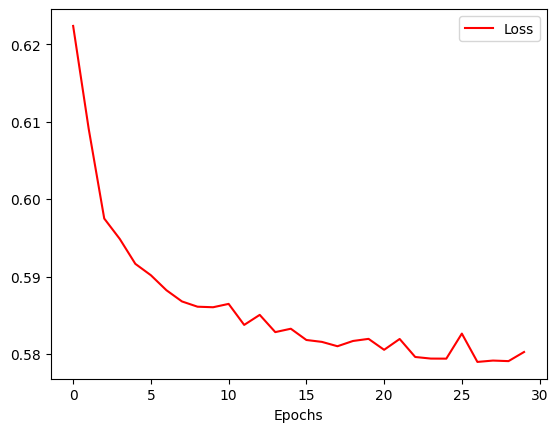

In [17]:
time_axis = np.arange(len(losses))
plt.plot(time_axis, losses, label='Loss', color='red')
plt.xlabel('Epochs')
plt.legend()
plt.show()

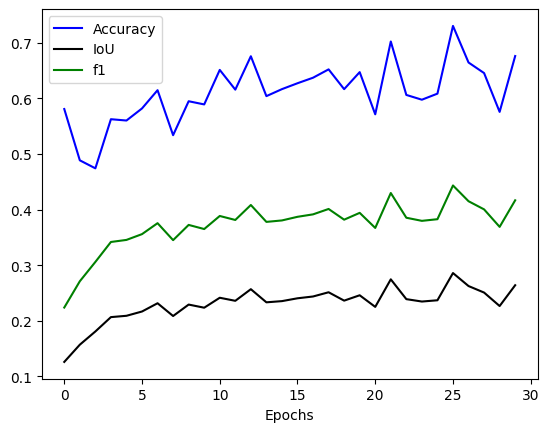

In [18]:
plt.plot(time_axis, accs, label='Accuracy', color='blue')
plt.plot(time_axis, ious, label='IoU', color='black')
plt.plot(time_axis, f1s, label='f1', color='green')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
save_model(model, REPO_DIR + "models/")

Model saved to ml-project-2-pytyeee/models/model_2023-12-20_0.pt
